# この実験について

1. この実験の目的  
  global_obsに応じて出力が変わらない（どのglobal_obsに対しても同じ結果がdecodeされる）という問題を抱えたSpeakerを修正する。
2. 仮説  
  **decoder**に対して、制約を緩めながら実験し、徐々に制約を課していくことで、機能不全を起こしている部分を特定し、改善することが可能。
3. 方針  
  まずは離散化をやめ、さらにモデルの表現力が非常に高い状態から始める。
4. 結果
  1. **離散化をやめ**、**隠れ層**に（5000,5000）のものを二つ挟めばいけた。**mの次元**は100。
  2. **隠れ層**（5000,5000）を一つでもいけた。
  3. **隠れ層**（2000,2000）だといける
  4. **隠れ層**（1000,1000）でもいける
  5. **mの次元**を小さく(6)してもいけた。
  6. **離散的**にすると？**だめ。**
  7. **隠れ層**のノードを増やすと？だめ
  8. 離散トークン**列**（10*10）にすると？だめ
  9. **GS周り**が終わっている説は？
      今回の場合、GSによるサンプリングは必要ないのではないかと考え、これをやめたところ、**うまくデコードされた**。
  10. 後半では表現mは変わらない方が良い(メッセージの一貫性を保つ観点から)と考えたので、スケジューラを導入した。






# 初期設定

In [1]:
# ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Gumbel
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy
from tqdm import tqdm
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 可視化のためにTensorBoardを用いるので, Colab上でTensorBoardを表示するための宣言を行う
%load_ext tensorboard

# torch.deviceを定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 環境構築

In [2]:
class State():

    def __init__(self, row=-1, column=-1):
        self.row = row
        self.column = column

    def __repr__(self):
        return "<State: [{}, {}]>".format(self.row, self.column)

    def clone(self):
        return State(self.row, self.column)

    def __hash__(self):
        return hash((self.row, self.column))

    def __eq__(self, other):
        return self.row == other.row and self.column == other.column

In [3]:
class Environment():

    def __init__(self, grid_type='A', move_prob=1.0):

        # Make a grid environment.
        self.grid_type = grid_type

        # grid is 2d-array. Its values are treated as an attribute.
        # Kinds of attribute is following.
        #  0: ordinary cell
        #  -1: damage cell (game end)
        #  1: reward cell (game end)
        #  9: block cell (can't locate agent)

        if self.grid_type=='A':
            # Environment A

            init_grid = [
                [9, 9, 9, 9, 9, 9, 9, 9, 9],
                [9, 0, 0, 0, 0, 0, 0, 0, 9],
                [9, 0, 9, 9, 9, 9, 9, 9, 9],
                [9, 0, 9, 9, 9, 9, 9, 9, 9],
                [9, 0, 0, 0, 0, 0, 0, 0, 9],
                [9, 0, 9, 9, 9, 9, 9, 9, 9],
                [9, 0, 9, 9, 9, 9, 9, 9, 9],
                [9, 0, 0, 0, 0, 0, 0, 0, 9],
                [9, 9, 9, 9, 9, 9, 9, 9, 9],
            ]

        else:
            raise Exception("'grid_type' must be 'A' or 'B'!")

        self.init_grid = init_grid # reward cellの位置が指定されていない（reward cellの位置はepospdeごとに変えたいので、self.reset()内で指定）
        

        self.reset()

        # Default reward is minus. Just like a poison swamp.
        # It means the agent has to reach the goal fast!
        self.default_reward = -0.04

        # Agent can move to a selected direction in move_prob.
        # It means the agent will move different direction
        # in (1 - move_prob).
        self.move_prob = move_prob

    def reset(self):
        # Locate the agent at init_state.

        start_pos = random.randint(0, 30)
        if start_pos>21:
            start_row, start_col = 4, 7
        elif start_pos==21:
            start_row, start_col = random.randint(1,7), 1
        else:
            start_row, start_col = 3 * (start_pos//7) + 1, start_pos%7 +1

        self.init_state = State(row=start_row, column=start_col)
        self.state = self.init_state.clone()

        # Reset grid
        self.grid = deepcopy(self.init_grid)
        # Decide position of reward cell randomly
        reward_pos = random.randint(0, 5)

        if self.grid_type=='A':
            # reward cell must be somewhere on one of the corridors
            reward_x = reward_pos % 3
            reward_y = reward_pos % 2
            if reward_y == 0:
                self.grid[1][reward_x*3+1] = 1
                #self.grid[1][7] = 1
            else:
                self.grid[-2][reward_x*3+1] = 1
                #self.grid[-2][7] = 1

        elif self.grid_type=='B':
            # reward cell must be somewhere on one of the corridors
            reward_x = reward_pos % 2
            reward_y = reward_pos % 3
            if reward_x == 0:
                self.grid[reward_y*3+1][1] = 1
            else:
                self.grid[reward_y*3+1][3] = 1

        return self.grid, self.state

    @property
    def row_length(self):
        return len(self.grid)

    @property
    def column_length(self):
        return len(self.grid[0])

    @property
    def actions(self):
        return [0, 1, 2, 3] # (UP, LEFT, DOWN, RIGHT)

    @property
    def states(self):
        states = []
        for row in range(self.row_length):
            for column in range(self.column_length):
                # Block cells are not included to the state.
                if self.grid[row][column] != 9:
                    states.append(State(row, column))
        return states


    def observation(self, partial=True):
        '''
        観測を出力する関数
            state : 環境における聞き手の状態(State(row, column))
            partial : 聞き手の部分観測である場合はTrue、話し手の全体観測である場合はFalse
        '''
        grid = torch.tensor(self.grid)
        row = self.state.row
        col = self.state.column

        # positions of ordinary cell
        pos_ordinary = (grid == 0)
        pos_ordinary[row, col] = False
        # position of reward cell
        pos_reward = (grid == 1)
        # position of block cell
        pos_block = (grid == 9)

        # initalize image (shape = (3 (r,g,b), *grid.shape))
        grid_img = torch.zeros((*grid.shape, 3))

        # color
        grid_img[:,:,0] += pos_ordinary * 255 + pos_block * 112.5
        grid_img[:,:,1] += pos_ordinary * 255 + pos_reward * 225 + pos_block * 112.5
        grid_img[:,:,2] += pos_ordinary * 255 + pos_block * 112.5
        grid_img[row, col, 2] = 225

        if partial:
            mask = np.zeros((*grid.shape, 3))
            mask[row-1:row+2, col-1:col+2, :] = 1
            grid_img *= mask

        return (grid_img/ 255.0).float()

# Speaker本体
今回の実験対象

In [46]:
def entropy(probs):
    return -torch.sum(probs * torch.log(torch.clamp(probs, min=1e-10)))

class Speaker(nn.Module):
    def __init__(self, m_tokens=2, m_length=10, buffer_size=150):
        super(Speaker, self).__init__()
        self.conv_enc1 = nn.Conv2d(3, 8, 3)
        self.conv_enc2 = nn.Conv2d(8, 16, 3)
        self.fc_enc1 = nn.Linear(16*5*5, 500)
        self.fc_enc2 = nn.Linear(500, m_tokens*m_length)

        self.fc_dec1 = nn.Linear(m_tokens*m_length, 500)
        self.fc_dec2 = nn.Linear(500, 500)
        self.fc_dec3 = nn.Linear(500, 3*9*9)

        self.speaker_memory =  torch.empty((buffer_size, 3, 9, 9), dtype=torch.float, device=device) # x_glbを記憶しておくバッファ
        self._memory_index = 0
        self.buffer_size = buffer_size

        self.m_tokens = m_tokens
        self.m_length = m_length

    def _encoder(self, x):
        h = F.relu(self.conv_enc1(x))
        h = F.relu(self.conv_enc2(h))
        h = h.view(-1, 16*5*5)
        h = F.relu(self.fc_enc1(h))
        h = self.fc_enc2(h)
        h = h.view(-1, self.m_length, self.m_tokens)
        #p = F.gumbel_softmax(h, tau=self.temperature)
        p=h###
        return p

    def _decoder(self, m):
        m = m.view(-1, self.m_length*self.m_tokens)
        h = F.relu(self.fc_dec1(m))
        h = F.relu(self.fc_dec2(h))
        h = self.fc_dec3(h)
        h = h.view(-1, 3, 9, 9)
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(h)
        return x

    def forward(self, x):
        p = self._encoder(x)
        label = torch.argmax(p, dim=-1)
        message = F.one_hot(label, num_classes=self.m_tokens) - p.detach() + p
        self.speaker_memory[self._memory_index] = torch.squeeze(x).clone() # x_glbを保存
        self._memory_index = (self._memory_index + 1) % self.buffer_size # リングバッファにする
        return message

    def loss(self):
        x = self.speaker_memory
        p = self._encoder(x)
        label = torch.argmax(p, dim=-1)
        m = F.one_hot(label, num_classes=self.m_tokens) - p.detach() + p
        y = self._decoder(m)
        return -entropy(torch.mean(p, dim=0)), torch.mean((x-y)**2)

# 学習

  0%|          | 0/200000 [00:00<?, ?it/s]

tensor(9.7976, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.2462, device='cuda:0', grad_fn=<MeanBackward0>)


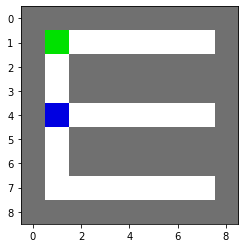

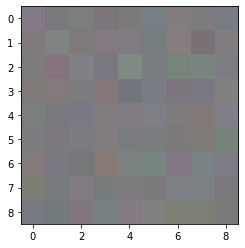

  5%|▍         | 9986/200000 [00:50<15:44, 201.14it/s]

tensor(-7.3573, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>)


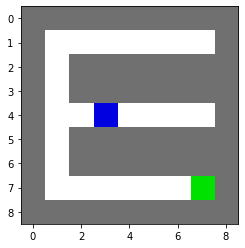

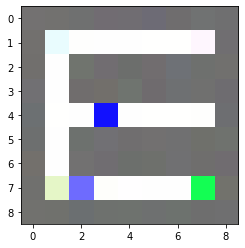

 10%|▉         | 19996/200000 [01:40<14:37, 205.22it/s]

tensor(-7.3558, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>)


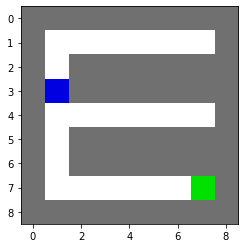

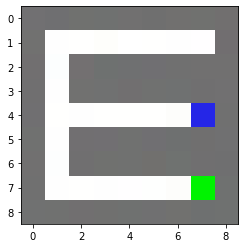

 15%|█▍        | 29982/200000 [02:30<13:57, 202.98it/s]

tensor(-7.3567, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)


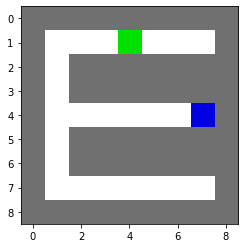

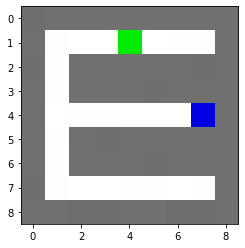

 20%|█▉        | 39993/200000 [03:21<13:50, 192.77it/s]

tensor(-7.3569, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)


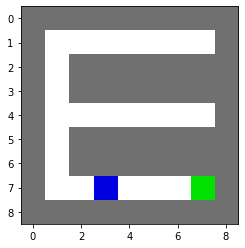

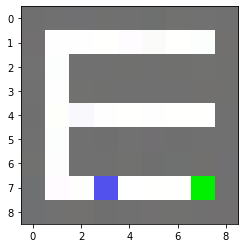

 25%|██▍       | 49996/200000 [04:11<12:23, 201.72it/s]

tensor(-7.3568, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)


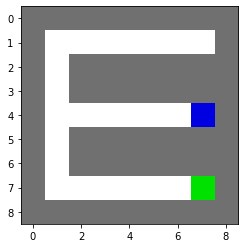

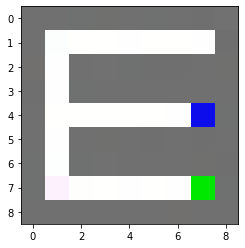

 30%|██▉       | 59994/200000 [05:04<11:51, 196.77it/s]

tensor(-7.3545, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)


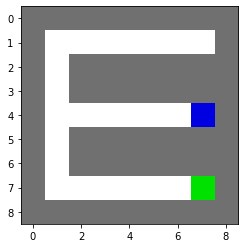

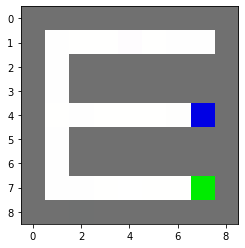

 35%|███▍      | 69988/200000 [05:55<11:20, 190.97it/s]

tensor(-7.3563, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)


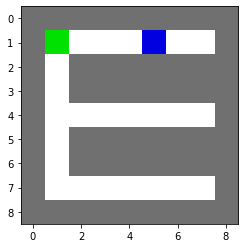

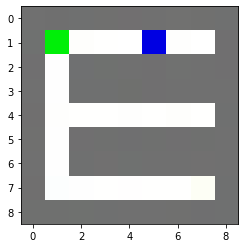

 40%|████      | 80000/200000 [06:46<09:58, 200.42it/s]

tensor(-7.3567, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)


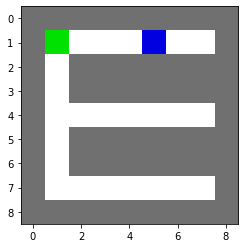

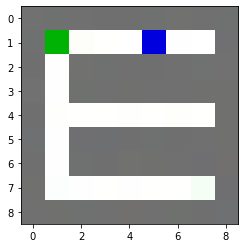

 45%|████▍     | 89980/200000 [07:36<09:07, 201.03it/s]

tensor(-7.3569, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)


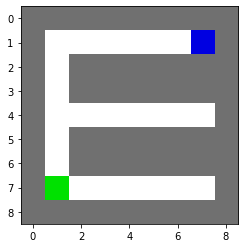

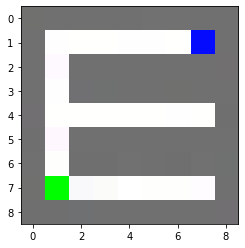

 50%|████▉     | 99989/200000 [08:26<08:00, 208.33it/s]

tensor(-7.3575, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)


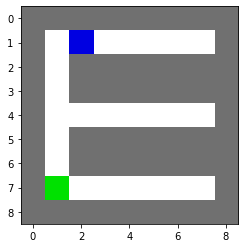

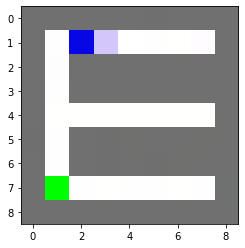

 55%|█████▍    | 109997/200000 [09:17<07:29, 200.42it/s]

tensor(-7.3573, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)


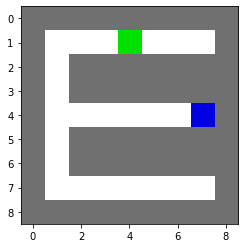

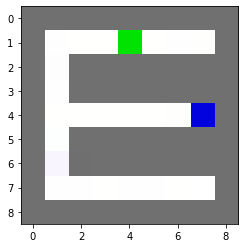

 60%|█████▉    | 119994/200000 [10:06<06:35, 202.12it/s]

tensor(-7.3573, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)


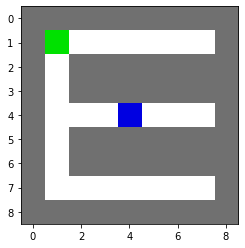

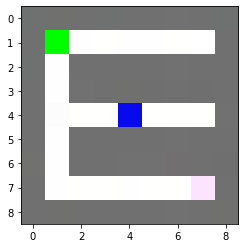

 65%|██████▍   | 129988/200000 [10:56<05:41, 204.84it/s]

tensor(-7.3570, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)


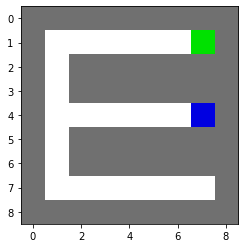

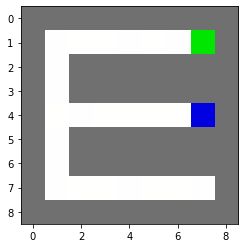

 70%|██████▉   | 139984/200000 [11:47<05:01, 198.75it/s]

tensor(-7.3574, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)


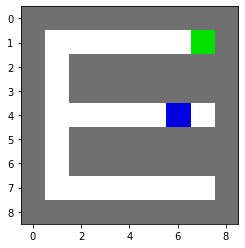

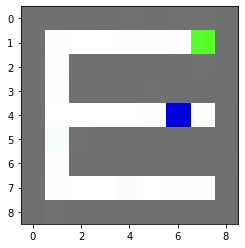

 75%|███████▍  | 149995/200000 [12:38<04:10, 199.36it/s]

tensor(-7.3573, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>)


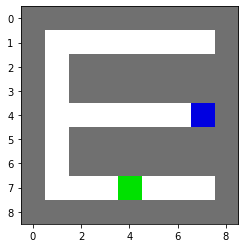

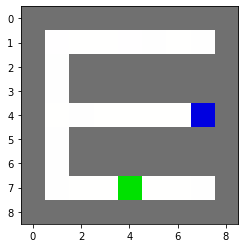

 80%|███████▉  | 159985/200000 [13:28<03:33, 187.35it/s]

tensor(-7.3574, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)


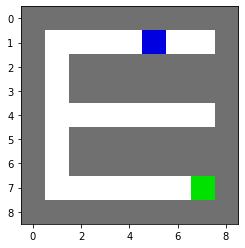

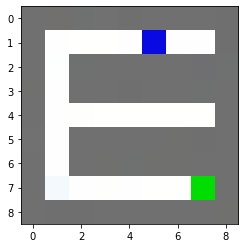

 85%|████████▍ | 169999/200000 [14:19<02:36, 192.18it/s]

tensor(-7.3574, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)


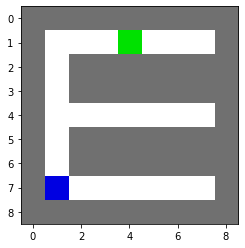

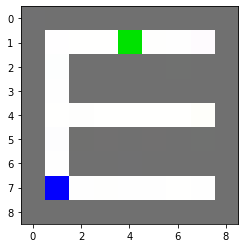

 90%|████████▉ | 179994/200000 [15:10<01:39, 201.22it/s]

tensor(-7.3575, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)


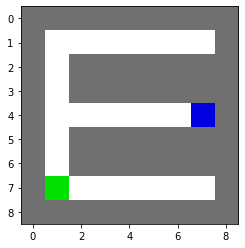

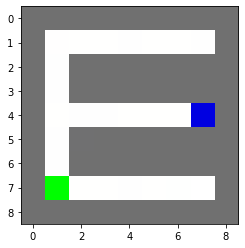

 95%|█████████▍| 189992/200000 [16:00<00:52, 189.07it/s]

tensor(-7.3574, device='cuda:0', grad_fn=<NegBackward0>) tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)


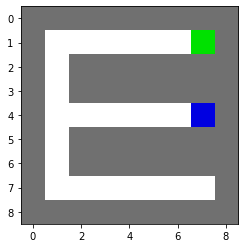

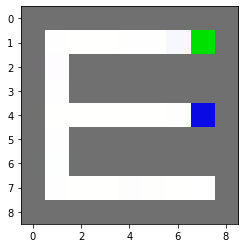

100%|██████████| 200000/200000 [16:51<00:00, 197.63it/s]


In [47]:
speaker = Speaker().to(device)
speaker_optimizer = torch.optim.Adam(speaker.parameters(), lr=1e-3, eps=1e-4)
# スケジューラー（スピーカー）
speaker_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(speaker_optimizer, 200000, eta_min=1e-6, last_epoch=-1, verbose = False)

env = Environment(grid_type='A')

for epoch in tqdm(range(200000)):
    x_glb = env.observation(partial=False).permute(2, 0, 1).reshape(-1, 3, 9, 9).to(device) # 話し手による全体観測
    m = speaker(x_glb)

    speaker_negent, speaker_rec = speaker.loss()
    speaker_loss = speaker_negent + speaker_rec
    speaker_optimizer.zero_grad()
    speaker_loss.backward()
    speaker_optimizer.step()
    env.reset()
    speaker_scheduler.step()
    if epoch%10000==0:
        print(speaker_negent, speaker_rec)
        env.reset()
        x_glb = env.observation(partial=False)
        plt.imshow(x_glb)
        plt.show()
        x_glb = x_glb.permute(2, 0, 1).reshape(-1, 3, 9, 9).to(device) 
        m = speaker(x_glb)
        x_re = speaker._decoder(m)
        x_re = x_re.reshape(3, 9, 9).permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(x_re)
        plt.show()

# 結果

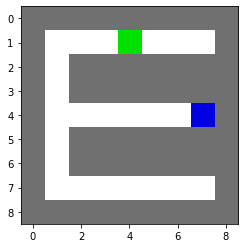

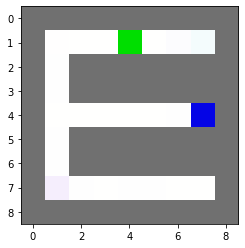

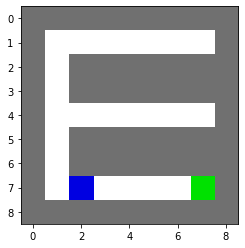

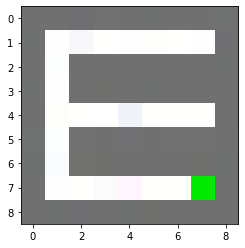

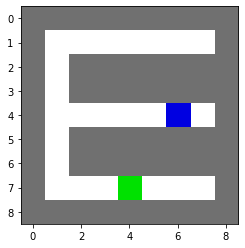

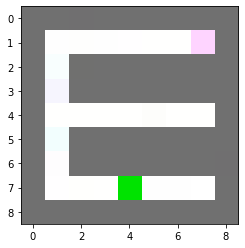

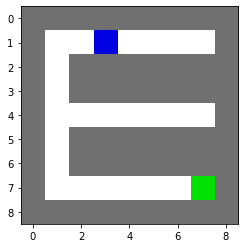

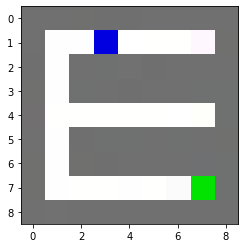

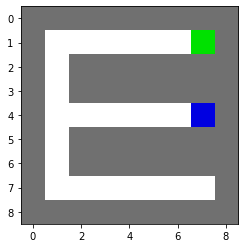

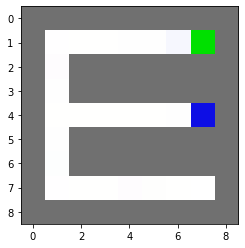

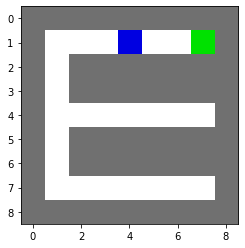

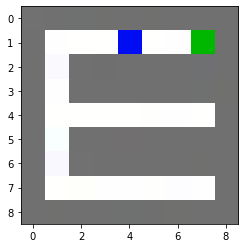

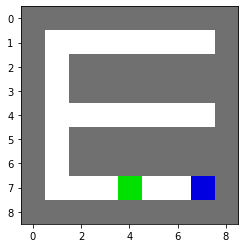

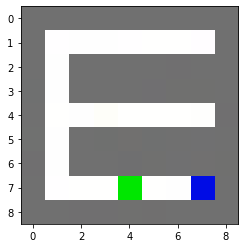

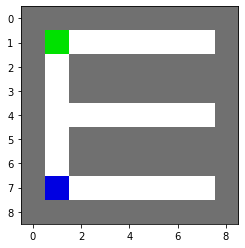

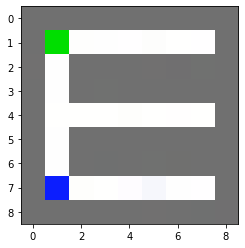

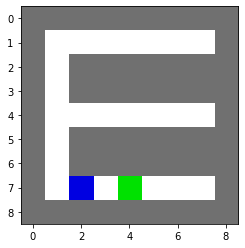

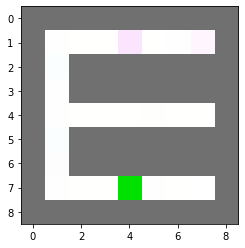

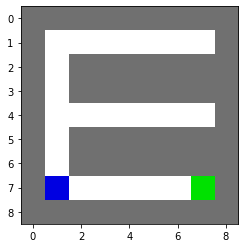

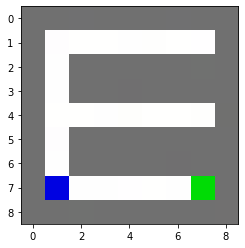

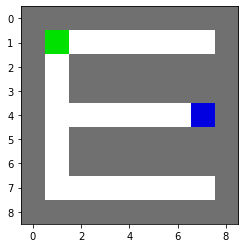

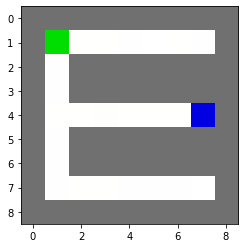

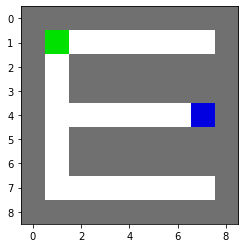

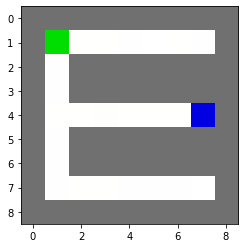

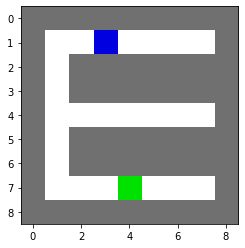

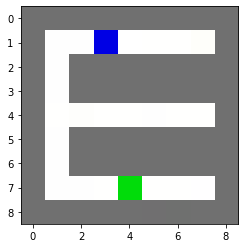

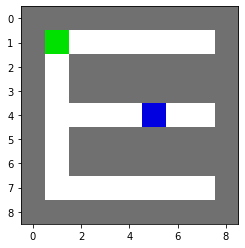

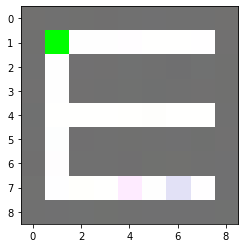

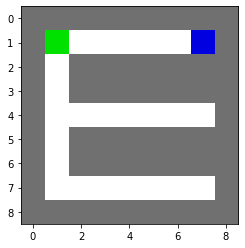

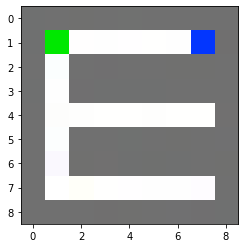

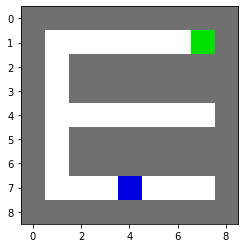

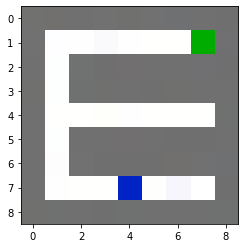

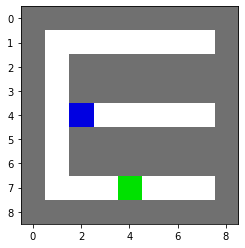

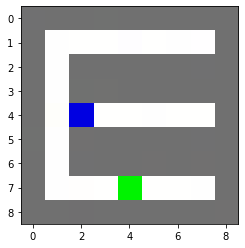

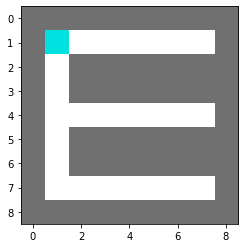

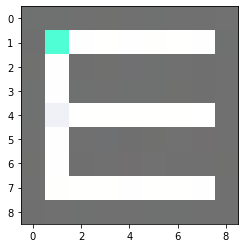

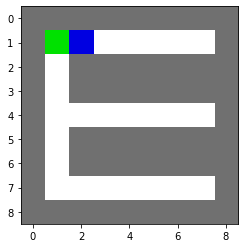

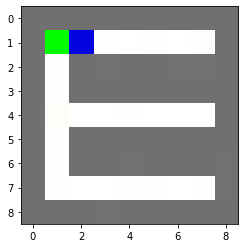

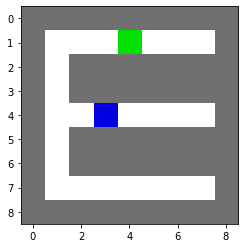

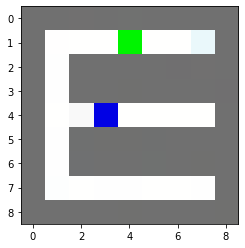

In [48]:
for _ in range(20):
    env.reset()
    x_glb = env.observation(partial=False)
    plt.imshow(x_glb)
    plt.show()
    x_glb = x_glb.permute(2, 0, 1).reshape(-1, 3, 9, 9).to(device) 
    m = speaker(x_glb)
    x_re = speaker._decoder(m)
    x_re = x_re.reshape(3, 9, 9).permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(x_re)
    plt.show()